In [1]:
include("IIT_PhiR_tools.jl");

using DelimitedFiles
using Random,Distributions,CausalityTools, DelimitedFiles


In [2]:
function IMf(x,y)
    
    ps1 = probabilities(Dataset(x));
    
    h1 = ComplexityMeasures.entropy(ps1)

    ps2 = probabilities(Dataset(y));

    h2 = ComplexityMeasures.entropy(ps2)

    ps3 = probabilities(Dataset([x y]));

    h3 = ComplexityMeasures.entropy(ps3)

    return h1+h2-h3
end

function RedSinIndex(S,Y)
    
    Ss = IMf(S,Y)
    
    nt = size(S)[2]
    
    RSI = 1*Ss
    
    for i in 1:nt
       
        RSI -=  IMf(S[:,i],Y)
        
    end
    
    return RSI
end

function PID(T,X)
    
    RR = minimum([IMf(T,X[:,1]),IMf(T,X[:,2])])
    
    ru1 = IMf(X[:,1],T)
    ru2 = IMf(X[:,2],T)
        
    U1 = ru1 - RR

    U2 = ru2 - RR
    
    Syn = IMf(X,T) - ru1 - ru2 + RR
        
    return [RR,U1,U2,Syn]
end


PID (generic function with 1 method)

In [4]:
allfiles = readdir()

filesR = [i for i in allfiles if occursin(".csv", i)]
    
filesR = sort(filesR,by=x->parse(Int32,split(x,"_")[end-3]))

24-element Vector{String}:
 "Time_serie_Pyrp22_Simdt_0.0125_tbin_1_CoincRat_0.0086_.csv"
 "Time_serie_Pyrp22_Simdt_0.0125_tbin_1_CoincRat_0.0192_.csv"
 "Time_serie_Pyrp22_Simdt_0.0125_tbin_1_CoincRat_0.233_.csv"
 "Time_serie_Pyrp22_Simdt_0.0125_tbin_1_CoincRat_1.0_.csv"
 "Time_serie_Pyrp22_Simdt_0.0125_tbin_2_CoincRat_0.0086_.csv"
 "Time_serie_Pyrp22_Simdt_0.0125_tbin_2_CoincRat_0.0192_.csv"
 "Time_serie_Pyrp22_Simdt_0.0125_tbin_2_CoincRat_0.233_.csv"
 "Time_serie_Pyrp22_Simdt_0.0125_tbin_2_CoincRat_1.0_.csv"
 "Time_serie_Pyrp22_Simdt_0.0125_tbin_4_CoincRat_0.0086_.csv"
 "Time_serie_Pyrp22_Simdt_0.0125_tbin_4_CoincRat_0.0192_.csv"
 "Time_serie_Pyrp22_Simdt_0.0125_tbin_4_CoincRat_0.233_.csv"
 "Time_serie_Pyrp22_Simdt_0.0125_tbin_4_CoincRat_1.0_.csv"
 "Time_serie_Pyrp22_Simdt_0.0125_tbin_6_CoincRat_0.0086_.csv"
 "Time_serie_Pyrp22_Simdt_0.0125_tbin_6_CoincRat_0.0192_.csv"
 "Time_serie_Pyrp22_Simdt_0.0125_tbin_6_CoincRat_0.233_.csv"
 "Time_serie_Pyrp22_Simdt_0.0125_tbin_6_CoincRat_1.0_.cs

In [9]:

timebin = []
CoincRat = []

for i in 1:length(filesR)
    
    append!(timebin,parse(Int32,split(filesR[i],"_")[end-3]))
    append!(CoincRat,parse(Float32,split(filesR[i],"_")[end-1]))
        
end
  

In [10]:
SS = []

PIDs = zeros(Float64,4,length(filesR))

tau = 1

for i in 1:length(filesR)
    
    X = readdlm(filesR[i], ',', Int,skipstart=1);

    y = X[1+tau:end,1]
    x = X[1:end-tau,2:end]

    append!(SS,RedSinIndex(x,y))
    
    PIDs[:,i] = PID(y,x)
    
end


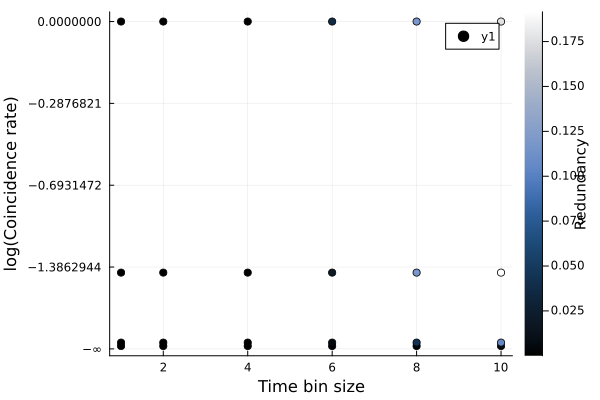

In [36]:

scatter(timebin, CoincRat; zcolor=PIDs[1,:], color=:oslo,xaxis=("Time bin size"),yaxis=("log(Coincidence rate)",log),colorbar_title="Redundancy")


In [11]:
using Plots

┌ Warning: Skipped marker arg o.
└ @ Plots ~/.julia/packages/Plots/p3KMq/src/args.jl:1147
┌ Warning: Skipped marker arg o.
└ @ Plots ~/.julia/packages/Plots/p3KMq/src/args.jl:1147
┌ Warning: Skipped marker arg o.
└ @ Plots ~/.julia/packages/Plots/p3KMq/src/args.jl:1147
┌ Warning: Skipped marker arg o.
└ @ Plots ~/.julia/packages/Plots/p3KMq/src/args.jl:1147


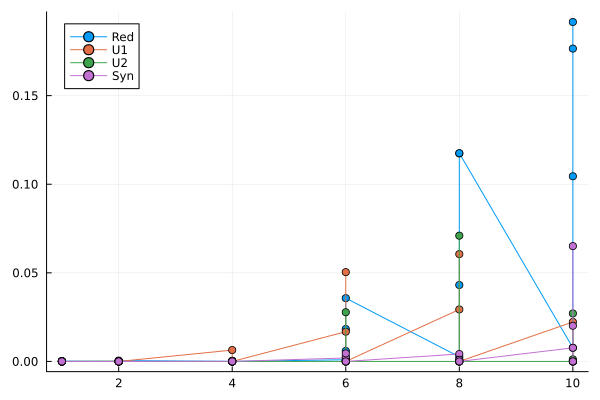

In [12]:

plot()

Label = ["Red","U1","U2","Syn"]

for i in 1:4
    plot!(timebin,PIDs[i,:],label=Label[i])
end

current()

In [106]:
using PyCall

In [ ]:
py"""

from itertools import combinations

def PID_collec(n):

    ee = [ i for i in range(n+1)]

    Collec = [{}]
    
    for k in range(1,len(ee)):

        Collec += [set(i) for i in combinations(ee[1:len(ee)], k)]

    Siz = np.zeros(len(Collec),dtype=np.int8)
    
    for k in range(len(Collec)):
        
        Siz[k] = len(Collec[k])
        
    return [Collec],Siz
    
def Labels(x,Collec):

    Lab = np.zeros(len(Collec),dtype=np.int8)
    
    for i in range(1,len(Collec)):

        for k in range(len(x)):

            if x[k] == Collec[i]:
    
                Lab[i] = 1

    return Lab

def LabtoCol(Lb,Collec0):

    Collecs = 1*Collec0
    
    for i in range(len(Lb)):
        
        if Lb[i]==0:
            
            Collecs[i] = {}
            
    return Collecs

def RedFuncTest(CollecL,LatEl,Collec0,Siz):

    LB = []
    ln = len(Collec0)

    for m in range(len(CollecL)):
    
        Collec = CollecL[m]

        for j in range(len(Collec)):

            for i in range(1,ln):
    
                CollecS = 1*Collec

                s = 1

                if Collec[i] != {}:

                    #for k in range(i-1,-1,-1):
                    for k in range(0,i,1):
                        
                        if Siz[k]<Siz[i]:
                            
                            for e in list(Collec[i]):

                                if e not in list(Collec[k]):

                                    s = 1*s

                                else:

                                    s = 0*s

                    if s == 1:

                        CollecS[i] = {}

                        lab = [(CollecS[i] != {})*1 for i in range(len(Collec))]

                        if (lab not in LB)and(lab not in LatEl[-1]):

                            LB.append(lab)

    LatEl.append(LB)
    
    CollecS = [LabtoCol(LB[i],Collec0) for i in range(len(LB))]
    
    return LatEl,CollecS

def Atomlab(latel,Collec0):
    
    labC = LabtoCol(latel,Collec0)

    lab0 = []

    i = 1

    print(labC)

    st = labC[-i]

    for e in labC[-1]:

        print(e)

        i = 1

        while i<len(labC):

                for j in range(len(labC)-1,-1,-1):

                    if e in labC[j]:

                        st = labC[j]

                i += 1

        lab0.append(st)

    lab = []

    for i in lab0:

        for j in lab0:

            if i!=j:

                s = 1

                for e in i:

                    if e in j:

                        s = 0

                if s!=0:
                    
                    if i not in lab:
                        lab.append(i)

    return lab

def flatten_concatenation(matrix):
    
    flat_list = []
    
    for row in matrix:
        
        flat_list += row
        
    return flat_list

def ChangeLab(AtomsCode,Collec0,Siz):

    Idx = np.where(np.array(AtomsCode)==1)[0]

    nn = 0

    CC = Collec0*1

    for ic in range(len(AtomsCode)):

        if AtomsCode[ic]==0:
            CC[ic] = {}

    Res = []

    while nn<len(Idx):

        idx = Idx[nn]

        if CC[idx]!={}:

            cc = CC[idx]

            ix = np.where(Siz>=Siz[idx]+1)[0]

            for ii in ix:

                if cc.issubset(CC[ii]):

                    CC[ii] = {}

        nn += 1

    for i in CC:
        if i!={}:
            Res.append(i)

    return Res

def RedVec(sXX):

    B = []
    
    for i in range(len(sXX)):

        xx = str(sXX[i]).split(":")

        xx = ["X_"+xx[i] for i in range(len(xx))]

        red = ""

        if len(xx)>1:

            red = "\min\{"

            for xi in xx[:-1]:
                red += " I("+xi + ',Y) , '

            red += " I("+xx[-1]+',Y) \}'

        else:
            red = "I("+xx[0]+",Y)"
        
        B.append(Symbol(red))
        
    return B

def LabX(sXX):

    B = []

    for nn in range(len(sXX)):

        xx = str(sXX[nn]).split(":")

        xx = ["X_"+xx[i] for i in range(len(xx))]

        lab = "\{"

        if len(xx)>1:
            for xi in xx[:-1]:

                lab += xi + ':'

            lab += xx[-1]+"\}"

        else:
            lab += xx[-1]+"\}"
        
        B.append(Symbol(lab))
        
    return B

def RedLattice(n):

    CollecL,Siz = PID_collec(n)

    Collec0 = CollecL[0]

    lab = [(Collec0[i] != {})*1 for i in range(len(Collec0))]

    LatEl = []

    LatEl.append([lab])

    while (sum(LatEl[-1][0]) > 1):

        LatEl, CollecL = RedFuncTest(CollecL,LatEl,Collec0,Siz)
    
    LatEl0 = []

    for i in range(len(LatEl)):

        for j in range(len(LatEl[i])):

            LatEl0.append(LatEl[i][j])

    Natoms = len(LatEl0)

    Levels = [np.sum(LatEl0[i]) for i in range(len(LatEl0))]

    mS = np.max(Siz)

    for i in range(mS+1):

        LatEl0[0][np.where(Siz)==i]

    XX = [ChangeLab(i,Collec0,Siz) for i in LatEl0]
    
    AA = np.zeros([Natoms,Natoms])

    for i in range(len(LatEl0)):

        ap = LatEl0[i]

        idx = np.where(np.array(Levels)>=Levels[i])[0]

        for j in range(len(idx)):

            a = LatEl0[idx[j]]

            s = 1

            for k in range(len(ap)):

                if ap[k]==1 and a[k]!=ap[k]:

                    s = 0

            if s==1: 
                
                AA[i,idx[j]] = 1
    
    return XX,AA,Collec0

"""

In [4]:
using Distributions

mean = [1.,1.]

a = 0.

C = [1. a; a 1.]

d1 = MvNormal(mean, C)

x = (rand(d1, 1000).>mean)'

#d0 = Normal(sum(x)./length(x), 0.5)
#noise = rand(d0,10000).>0.5
#y = (reduce(*,x,dims=2)[:].>0);

y = reduce(+,x,dims=2)[:].>0

#y = (y.!=2).||(y.==0);

RedSinIndex(x,y)

0.1942710051791705

In [5]:
XX,AA,Collec0 = py"""RedLattice"""(3)


LoadError: LoadError: UndefVarError: @py_str not defined
in expression starting at In[5]:1